In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

stocks = pd.read_csv("~/Stock_Prediction_ML/StockPredictions/Stock_Predictions/data/S&P_500_GOOGFIN_3MO.csv")

Using TensorFlow backend.


In [2]:
def get_stock_data(name):
    return stocks.loc[stocks['Stock'] == name]

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

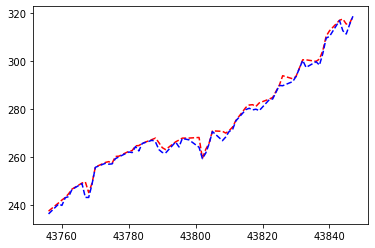

In [4]:
AAPL = get_stock_data('AAPL')

plt.plot(AAPL.Date, AAPL.High, 'r--', AAPL.Date, AAPL.Close, 'b--')

In [5]:
u_stocks = np.unique(stocks['Stock'])
labels, uniques = pd.factorize(stocks['Stock'])
labels.transpose
stocks['ID'] = labels
stocks_id = stocks.drop(['Stock'], axis = 1)
print(stocks_id)
AAPL = AAPL.set_index('Date')
AAPL = AAPL.drop(['Stock'], axis = 1)
print(AAPL)
AAPL_val = AAPL.values
AAPL_val = AAPL_val.astype('float64')

        Date    Open    High     Low   Close   Volume   ID
0      43756   74.00   74.82   73.77   74.57  2121895    0
1      43759   74.88   75.51   74.69   75.48  1739523    0
2      43760   75.68   76.33   74.64   74.69  1327981    0
3      43761   75.02   75.89   74.68   74.98  1828337    0
4      43762   75.03   75.11   74.46   75.00  1582478    0
...      ...     ...     ...     ...     ...      ...  ...
31810  43843  136.07  136.75  135.46  136.51  1801255  514
31811  43844  136.42  137.28  135.52  137.27  1848833  514
31812  43845  137.41  139.00  137.34  138.54  1859576  514
31813  43846  138.78  139.40  138.02  139.24  1822882  514
31814  43847  139.62  140.40  138.86  140.16  1993175  514

[31815 rows x 7 columns]
         Open    High     Low   Close    Volume
Date                                           
43756  234.59  237.58  234.29  236.41  24377166
43759  237.52  240.99  237.32  240.51  22367483
43760  241.16  242.20  239.62  239.96  22684001
43761  242.10  243.24  241

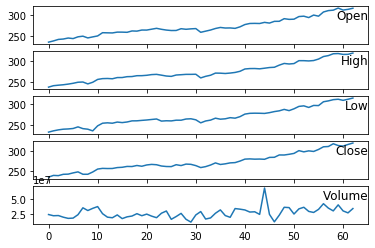

In [6]:
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(AAPL_val[:, group])
    plt.title(AAPL.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(AAPL_val)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.000000   0.000000   0.000000   0.000000   0.221735  0.035684
2   0.035684   0.042016   0.037542   0.049806   0.186710  0.080015
3   0.080015   0.056925   0.066039   0.043124   0.192226  0.091463
4   0.091463   0.069739   0.085863   0.082240   0.144274  0.120814
5   0.120814   0.088960   0.093173   0.087099   0.109133  0.104372


In [8]:
values = reframed.values

In [9]:
n_train = int(values.shape[0] * 0.67)
train = values[:n_train,:]
test = values[n_train:,:]

In [10]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [11]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(41, 1, 5) (41,) (21, 1, 5) (21,)


Train on 41 samples, validate on 21 samples
Epoch 1/50
 - 2s - loss: 0.3054 - val_loss: 0.7254
Epoch 2/50
 - 0s - loss: 0.2851 - val_loss: 0.6894
Epoch 3/50
 - 0s - loss: 0.2649 - val_loss: 0.6532
Epoch 4/50
 - 0s - loss: 0.2447 - val_loss: 0.6165
Epoch 5/50
 - 0s - loss: 0.2248 - val_loss: 0.5794
Epoch 6/50
 - 0s - loss: 0.2046 - val_loss: 0.5414
Epoch 7/50
 - 0s - loss: 0.1840 - val_loss: 0.5024
Epoch 8/50
 - 0s - loss: 0.1634 - val_loss: 0.4624
Epoch 9/50
 - 0s - loss: 0.1442 - val_loss: 0.4215
Epoch 10/50
 - 0s - loss: 0.1254 - val_loss: 0.3796
Epoch 11/50
 - 0s - loss: 0.1070 - val_loss: 0.3364
Epoch 12/50
 - 0s - loss: 0.0900 - val_loss: 0.2925
Epoch 13/50
 - 0s - loss: 0.0747 - val_loss: 0.2477
Epoch 14/50
 - 0s - loss: 0.0600 - val_loss: 0.2017
Epoch 15/50
 - 0s - loss: 0.0481 - val_loss: 0.1582
Epoch 16/50
 - 0s - loss: 0.0432 - val_loss: 0.1202
Epoch 17/50
 - 0s - loss: 0.0494 - val_loss: 0.0883
Epoch 18/50
 - 0s - loss: 0.0607 - val_loss: 0.0717
Epoch 19/50
 - 0s - loss: 0.0

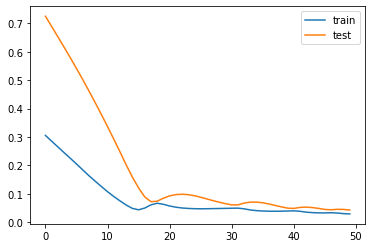

In [12]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test), verbose=2,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
# make a prediction
print(X_test.shape)
print(X_test)
print(X_test.size)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[2]))
y_pred = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

# invert scaling for forecast
inv_y_pred = np.concatenate((y_pred, X_test[:,1:]), axis=1)
inv_y_pred = scaler.inverse_transform(inv_y_pred)
inv_y_pred = inv_y_pred[:, 0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = math.sqrt(mean_squared_error(inv_y, inv_y_pred))
print('Test RMSE: %.3f' % rmse)

(21, 1, 5)
[[[0.54780173 0.54448004 0.55148061 0.53449951 0.2949096 ]]

 [[0.55060285 0.54608181 0.55544542 0.52636054 0.30273291]]

 [[0.54694921 0.53721045 0.55333912 0.5297619  0.22608836]]

 [[0.5801973  0.55532282 0.548507   0.52271623 1.        ]]

 [[0.55949336 0.57503696 0.57093297 0.57810982 0.22697608]]

 [[0.61015711 0.58292262 0.60252757 0.5813897  0.00811022]]

 [[0.61174035 0.64563825 0.62458184 0.64990282 0.20355474]]

 [[0.68846669 0.69480039 0.66695577 0.64856657 0.43463362]]

 [[0.66824991 0.67902908 0.63102466 0.66946064 0.42533879]]

 [[0.67397394 0.69122721 0.68430182 0.69533528 0.23690564]]

 [[0.75082207 0.77649088 0.75455334 0.77672498 0.38790745]]

 [[0.76190476 0.77624446 0.77078429 0.74125364 0.43534716]]

 [[0.72098405 0.76860522 0.72432165 0.77004373 0.31353763]]

 [[0.79466569 0.78018728 0.78292653 0.75291545 0.28274225]]

 [[0.76202655 0.82380483 0.77896171 0.81122449 0.37360035]]

 [[0.8847887  0.89760966 0.89096766 0.88945578 0.53970117]]

 [[0.92570941

In [24]:
print(inv_y_pred)

[279.88384175 279.93776536 278.8770296  288.23402319 281.09296286
 280.09695696 285.38048171 290.97749063 290.11324959 289.58971882
 297.25814202 297.49277187 295.07735356 296.74804077 299.36429979
 308.54561342 308.83869395 311.48948111 313.98918135 309.31237793
 310.56234061]


In [25]:
print(inv_y)

[279.8  279.5  282.23 280.53 284.69 284.82 291.12 289.46 289.93 296.24
 297.15 293.79 299.84 297.16 307.24 310.6  311.64 316.7  311.85 313.59
 316.27]


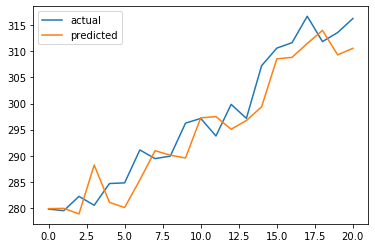

In [26]:
plt.plot(range(inv_y.shape[0]),inv_y, label='actual')
plt.plot(range(inv_y_pred.shape[0]), inv_y_pred, label='predicted')
plt.legend()
plt.show()